In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg



In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14209696657883751354
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1734816564
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2795712169308816531
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
import tensorflow as tf

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)




In [31]:
LEARNING_RATE = 0.0001
epoch = 20
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

In [5]:
!git clone {repo_url} --quiet

In [5]:
df = pd.read_csv("medical-ai/labels.csv")
df.head()


,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [6]:
df["label"].unique()

array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass',
       'Nodule', 'Pneumonia', 'Pneumothorax', 'No Finding'], dtype=object)

In [7]:
finding = "Cardiomegaly"

In [8]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]

In [9]:
len(positives)

146

In [10]:
train_ratio = 0.8 
test_ratio  = 0.2

In [11]:
n = len(positives)
n

146

In [12]:
train_n = int(n * train_ratio)
test_n  = int(n * test_ratio)

In [13]:
train_n , test_n

(116, 29)

In [14]:
train_labels = pd.concat([positives[:train_n] , negatives[:train_n] ] )
test_labels  = pd.concat([positives[train_n:] , negatives[train_n:]])

In [15]:
train_labels.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
161,00005066_030.jpg,2500,2048,Cardiomegaly,277.0,459.0,817.0,760.0,AP
162,00009608_024.jpg,2500,2048,Cardiomegaly,394.0,402.0,759.0,743.0,AP
163,00000661_000.jpg,2021,2021,Cardiomegaly,298.0,437.0,846.0,865.0,PA
164,00019018_007.jpg,3056,2544,Cardiomegaly,366.0,520.0,809.0,787.0,AP
165,00000211_041.jpg,2500,2048,Cardiomegaly,224.0,416.0,736.0,846.0,AP


In [16]:
rootdir = "medical-ai/images/"

In [17]:
rootdir = "medical-ai/images/"
os.makedirs(rootdir +finding + "/test/positive/"  ,  exist_ok=True)
os.makedirs(rootdir +finding + "/train/positive/" ,  exist_ok=True)
os.makedirs(rootdir +finding + "/test/negative/"  ,  exist_ok=True)
os.makedirs(rootdir +finding + "/train/negative/" ,  exist_ok=True)


In [19]:
for idx , image in positives[:train_n].iterrows():
    source = rootdir+image['filename']
    dst = rootdir + finding + "/train/positive/" + image['filename'] 
    shutil.copy(source , dst)
    
    

In [20]:
for idx , image in positives[train_n:].iterrows():
    source = rootdir + image['filename']
    dst    = rootdir + finding + "/test/positive/" + image["filename"]
    shutil.copy(source , dst)

In [21]:
for idx , image in negatives[:train_n].iterrows():
    source = rootdir + image["filename"]
    dst    = rootdir + finding + "/train/negative/" + image["filename"]
    shutil.copy(source , dst)

In [22]:
for idx , image in negatives[train_n:].iterrows():
    source = rootdir + image["filename"]
    dst    = rootdir + finding + "/test/negative/" + image["filename"]
    shutil.copy(source , dst)

In [18]:
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [19]:
positive_img  , negative_img = [] , []
IMAGE_HEIGHT , IMAGE_WIDTH = 256,256

for idx , row in positives[:5].iterrows():
    img_path = rootdir + row["filename"]
    img = Image.open(img_path).resize((IMAGE_WIDTH ,IMAGE_HEIGHT))
    positive_img.append(load_image_into_numpy_array(img))

for idx , row in negatives[:5].iterrows():
    img_path = rootdir + row["filename"]
    img = Image.open(img_path).resize((IMAGE_WIDTH , IMAGE_HEIGHT))
    negative_img.append(load_image_into_numpy_array(img))

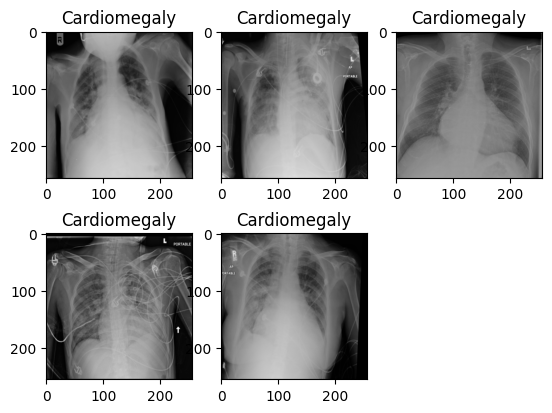

In [20]:
for idx , img in enumerate(positive_img):
    plt.subplot(2,3 , idx+1)
    plt.title(finding)
    plt.imshow(positive_img[idx])

plt.show()

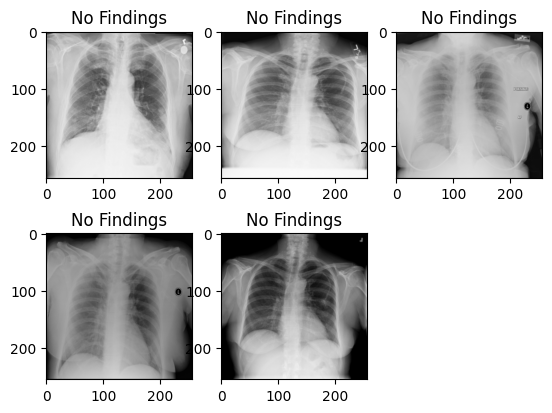

In [21]:
for idx , img in enumerate(negative_img):
    plt.subplot(2,3,idx+1)
    plt.title("No Findings")
    plt.imshow(negative_img[idx])
plt.show()

## training model


In [47]:
from tensorflow.keras import backend as K
K.clear_session()

In [48]:
import tensorflow as tf

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [49]:
pre_train_model = InceptionV3(
    input_shape= (IMAGE_HEIGHT , IMAGE_WIDTH ,3) , weights="imagenet" , include_top= False
)

for layer in pre_train_model.layers:
    layer.trainable = False

last_layer = pre_train_model.get_layer('mixed7')
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(256 , activation='relu')(x)
x = layers.Dropout(0.2)(x) 
x = layers.Dense(1 , activation="sigmoid")(x) 

model = Model(pre_train_model.input , x)
model.compile(loss = "binary_crossentropy" , optimizer= "adam" , metrics=["accuracy"] )



In [25]:
base_dir = rootdir 
train_dir = os.path.join(base_dir  , finding , "train" )
test_dir  = os.path.join(base_dir  , finding , "test")

In [26]:
train_pos_dir = os.path.join(train_dir , "positive")
train_neg_dir = os.path.join(train_dir , "negative")

test_pos_dir  = os.path.join(test_dir , "positive")
test_neg_dir  = os.path.join(test_dir , "negative")

In [27]:
train_datagen = ImageDataGenerator(
    rescale= 1./255 , 
    rotation_range= 40 , 
    width_shift_range= 0.2 , 
    height_shift_range= 0.2 , 
    shear_range= 0.2 , 
    zoom_range= 0.2 , 
    horizontal_flip= False
)

val_datagen = ImageDataGenerator(rescale= 1./255)

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir , 
    target_size= (IMAGE_WIDTH ,IMAGE_HEIGHT) , 
    batch_size= 1 , 
    class_mode= "binary"
)

test_generator  = val_datagen.flow_from_directory(
    test_dir , 
    target_size = (IMAGE_WIDTH , IMAGE_HEIGHT) , 
    batch_size= 1 , 
    class_mode= "binary"
)

Found 232 images belonging to 2 classes.
Found 894 images belonging to 2 classes.


In [29]:
train_step = len(os.listdir(train_pos_dir)) *2
test_step  = len(os.listdir(test_pos_dir)) *2
train_step ,test_step

(232, 60)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [32]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_step,
      epochs=epoch,
      validation_data=test_generator,
      validation_steps=test_step)

Epoch 1/20
232/232 [==============================] - 12s 28ms/step - loss: 5.2237 - accuracy: 0.5776 - val_loss: 5.5278 - val_accuracy: 0.0500
Epoch 2/20
232/232 [==============================] - 6s 25ms/step - loss: 1.2620 - accuracy: 0.6078 - val_loss: 0.4068 - val_accuracy: 0.8833
Epoch 3/20
232/232 [==============================] - 6s 25ms/step - loss: 0.6253 - accuracy: 0.6940 - val_loss: 0.5221 - val_accuracy: 0.7500
Epoch 4/20
232/232 [==============================] - 6s 26ms/step - loss: 0.5865 - accuracy: 0.7328 - val_loss: 1.4028 - val_accuracy: 0.1500
Epoch 5/20
232/232 [==============================] - 6s 25ms/step - loss: 0.6398 - accuracy: 0.6552 - val_loss: 0.9666 - val_accuracy: 0.1667
Epoch 6/20
232/232 [==============================] - 6s 25ms/step - loss: 0.5887 - accuracy: 0.7543 - val_loss: 0.3860 - val_accuracy: 0.8333
Epoch 7/20
232/232 [==============================] - 6s 25ms/step - loss: 0.5916 - accuracy: 0.6940 - val_loss: 1.0484 - val_accuracy: 0.266

In [35]:
history.history["accuracy"] 

[0.5775862336158752,
 0.607758641242981,
 0.693965494632721,
 0.732758641242981,
 0.6551724076271057,
 0.7543103694915771,
 0.693965494632721,
 0.7025862336158752,
 0.7198275923728943,
 0.732758641242981,
 0.7370689511299133,
 0.7844827771186829,
 0.7758620977401733,
 0.7974137663841248,
 0.8017241358757019,
 0.7758620977401733,
 0.7715517282485962,
 0.7931034564971924,
 0.7543103694915771,
 0.8318965435028076]

In [36]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

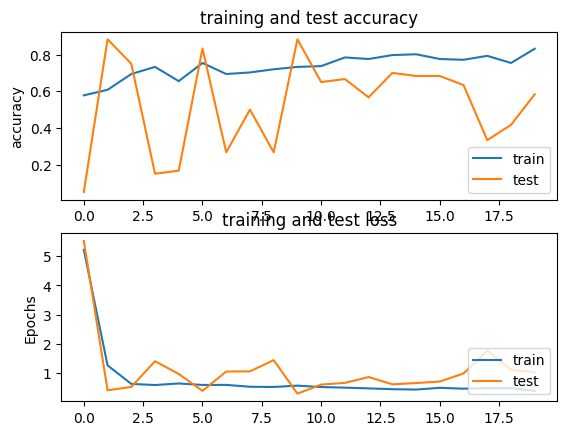

In [50]:
plt.subplot(2,1,1)
plt.plot(epochs , acc , label = "train")
plt.plot(epochs , val_acc , label = "test")
plt.ylabel("accuracy")
plt.title("training and test accuracy")
plt.legend(loc = "lower right")

plt.subplot(2,1,2)
plt.plot(epochs , loss , label = "train")
plt.plot(epochs , val_loss , label = "test")
plt.ylabel("Epochs")
plt.title("training and test loss")
plt.legend(loc = "lower right")

In [57]:
def predict_image(filename): 
    image = Image.open(filename).resize((IMAGE_WIDTH , IMAGE_HEIGHT))
    img_np = load_image_into_numpy_array(image)
    exp = np.true_divide(img_np , 255.0)
    expanded = np.expand_dims(exp , axis= 0)
    return model.predict(expanded)[0][0]

In [58]:
def show_df_row(row): 
    image_path = row["filepath"]
    image = Image.open(filename).resize((IMAGE_WIDTH , IMAGE_HEIGHT))
    img_np = load_image_into_numpy_array(image)
    exp = np.true_divide(img_np , 255.0)
    expanded = np.expand_dims(exp , axis= 0)
    pred =  model.predict(expanded)[0][0]

    guess = "neg"
    if pred > 0.5: guess = "pos"
    title = "Image: " +row["filename"] + "Label: "+row["label"] + "Guess: "+guesse+ " Score: "+str(pred)
    plt.title( title) 
    plt.imshow(img ) 
    plt.show() 
    return

In [59]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 [==============================] - 0s 53ms/step
Done inference!


In [36]:
df.head()

,filepath,filename,label,guess,confidence
0,medical-ai/images/Cardiomegaly\test\positive/0...,00013615_052.jpg,pos,pos,1.000000
1,medical-ai/images/Cardiomegaly\test\negative/0...,00000459_036.jpg,neg,pos,0.999991
2,medical-ai/images/Cardiomegaly\test\negative/0...,00000459_001.jpg,neg,pos,0.999964
3,medical-ai/images/Cardiomegaly\test\negative/0...,00000459_004.jpg,neg,pos,0.999935
4,medical-ai/images/Cardiomegaly\test\negative/0...,00000459_040.jpg,neg,pos,0.999880


1/1 [==============================] - 0s 59ms/step


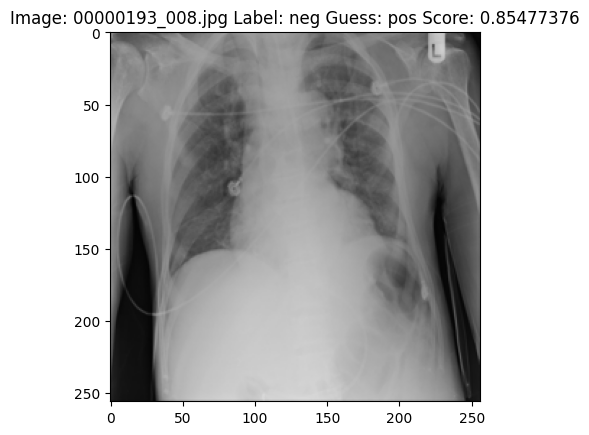

In [37]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [38]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,1.000000e+00
5,00000459_005.jpg,neg,pos,9.998719e-01
10,00000467_009.jpg,neg,pos,9.996952e-01
15,00000459_006.jpg,neg,pos,9.993248e-01
20,00010381_000.jpg,pos,pos,9.989715e-01
...,...,...,...,...
870,00000500_009.jpg,neg,neg,3.983839e-07
875,00000259_000.jpg,neg,neg,2.548981e-07
880,00000401_000.jpg,neg,neg,1.584707e-07
885,00000500_006.jpg,neg,neg,7.455534e-08


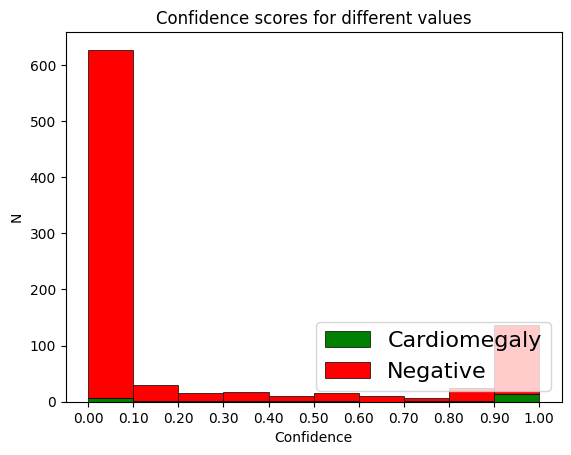

In [39]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [40]:
cutoff = 0.79 #@param {type:"slider", min:0, max:1, step:0.01}

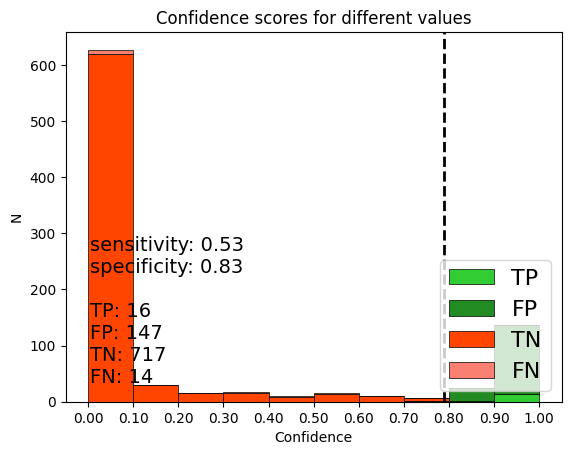

In [41]:
def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('Confidence')
  plt.ylabel('N')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff)

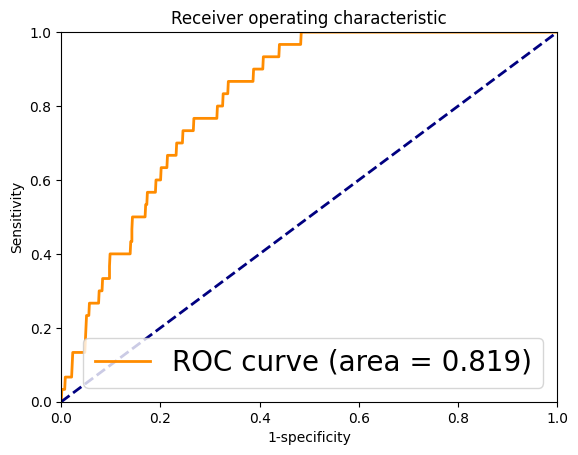

In [42]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()